# Time-explicit LCA of an electric vehicle


This notebook contains the code for the example case study of the bw_timex paper. Here, we do a time-explicit LCA of the life cycle of an electric vehicle (EV) and compare the results to the results from static and dynamic LCAs.

In [55]:
import bw2data as bd

bd.projects.set_current("timex")

## Prospective background databases

In this example, we use data from [ecoinvent v3.10](https://ecoinvent.org/), and create a set of prospective databases with [`premise`](https://github.com/polca/premise). We applied projections for the future electricity sectors using the SSP2-RCP19 pathway from the IAM IMAGE. 
In the [premise documentation](https://premise.readthedocs.io/en/latest/) you can find instructions for the creation of prospective background databases. 


In [56]:
db_2020 = bd.Database("ei310_IMAGE_SSP2_RCP19_2020_electricity")
db_2030 = bd.Database("ei310_IMAGE_SSP2_RCP19_2030_electricity")
db_2040 = bd.Database("ei310_IMAGE_SSP2_RCP19_2040_electricity")

## Case study setup

In this study, we consider the following production system for our ev. Purple boxes are foreground, cyan boxes are background (i.e., ecoinvent/premise).

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->ev_production
    powertrain_production(powertrain production):::ei-->ev_production
    battery_production(battery production):::ei-->ev_production
    ev_production(ev production):::fg-->driving
    electricity_generation(electricity generation):::ei-->driving
    driving(driving):::fg-->used_ev
    used_ev(used ev):::fg-->glider_eol(glider eol):::ei
    used_ev-->powertrain_eol(powertrain eol):::ei
    used_ev-->battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

### Modeling the production system

For our ev model we make the following assumptions:

In [57]:
ELECTRICITY_CONSUMPTION = 0.2 # kWh/km
MILEAGE = 150_000 # km
LIFETIME = 15 # years

# Overall mass: 1200 kg
MASS_GLIDER = 840 # kg
MASS_POWERTRAIN = 80 # kg
MASS_BATTERY = 280 # kg

First, we create a new foreground database:

In [58]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

Now, we create the foreground activities:


In [59]:
ev_production = foreground.new_node("ev_production", name="production of an electric vehicle", unit="unit")
ev_production['reference product'] = "electric vehicle"
ev_production.save()

driving = foreground.new_node("driving", name="driving an electric vehicle", unit="transport over an ev lifetime")
driving['reference product'] = "transport"
driving.save()

used_ev = foreground.new_node("used_ev", name="used electric vehicle", unit="unit")
used_ev['reference product'] = "used electric vehicle"
used_ev.save()

We take the actual process data from ecoinvent. However, the ecoinvent processes for the ev part production contain exchanges for the end of life treatment in the production processes already, which we want to separate. We fix this first by creating new activities without the eol processes:

In [60]:
for db in [db_2020, db_2030, db_2040]:
    for code in ["glider_production_without_eol", "powertrain_production_without_eol", "battery_production_without_eol"]:
        try:
            act = db.get(code=code)
            act.delete()
        except:
            pass
    
    glider_production = db.get(name="glider production, passenger car")
    glider_production_without_eol = glider_production.copy(code="glider_production_without_eol", database=db.name)
    glider_production_without_eol["name"] = "glider production, passenger car, without EOL"
    # glider_production_without_eol["reference product"] = "glider"
    glider_production_without_eol.save()
    for exc in glider_production_without_eol.exchanges():
        if exc.input["name"] == "market for used glider, passenger car":
            exc.delete()
    
    powertrain_production = db.get(name="powertrain production, for electric passenger car")
    powertrain_production_without_eol = powertrain_production.copy(code="powertrain_production_without_eol", database=db.name)
    powertrain_production_without_eol["name"] = "powertrain production, for electric passenger car, without EOL"
    # powertrain_production_without_eol["reference product"] = "powertrain"
    powertrain_production_without_eol.save()
    for exc in powertrain_production_without_eol.exchanges():
        if exc.input["name"] == "market for used powertrain from electric passenger car, manual dismantling":
            exc.delete()
    
    battery_production = db.get(name="battery production, Li-ion, LiMn2O4, rechargeable, prismatic")
    battery_production_without_eol = battery_production.copy(code="battery_production_without_eol", database=db.name)
    battery_production_without_eol["name"] = "battery production, Li-ion, LiMn2O4, rechargeable, prismatic, without EOL"
    # battery_production_without_eol["reference product"] = "battery"
    battery_production_without_eol.save()
    # For the battery, some waste treatment is buried in the process "battery cell production, Li-ion, 
    # LiMn2O4" - but not for the whole mass of the battery(?). For simplicity, we just leave it in there.

Now, we create the exchanges, starting with the ev production:

In [61]:
glider_production = db_2020.get(code="glider_production_without_eol")
powertrain_production = db_2020.get(code="powertrain_production_without_eol")
battery_production = db_2020.get(code="battery_production_without_eol")

ev_production.new_edge(input=ev_production, amount=1, type="production").save()

glider_to_ev = ev_production.new_edge(
    input=glider_production,
    amount=MASS_GLIDER, 
    type="technosphere"
)
powertrain_to_ev = ev_production.new_edge(
    input=powertrain_production, 
    amount=MASS_POWERTRAIN, 
    type="technosphere"
)
battery_to_ev = ev_production.new_edge(
    input=battery_production, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

... the end of life:

In [62]:
glider_eol = db_2020.get(name="treatment of used glider, passenger car, shredding")
powertrain_eol = db_2020.get(name="treatment of used powertrain for electric passenger car, manual dismantling")
battery_eol = db_2020.get(name="market for used Li-ion battery")

used_ev.new_edge(input=used_ev, amount=-1, type="production").save()  # -1 as this gets rid of a used car

used_ev_to_glider_eol = used_ev.new_edge(
    input=glider_eol,
    amount=-MASS_GLIDER,
    type="technosphere",
)
used_ev_to_powertrain_eol = used_ev.new_edge(
    input=powertrain_eol,
    amount=-MASS_POWERTRAIN,
    type="technosphere",
)
used_ev_to_battery_eol = used_ev.new_edge(
    input=battery_eol,
    amount=-MASS_BATTERY,
    type="technosphere",
)

...and, finally, driving:

In [63]:
electricity_production = db_2020.get(name="market group for electricity, low voltage", location="WEU")

driving.new_edge(input=driving, amount=1, type="production").save()

driving_to_used_ev = driving.new_edge(input=used_ev, amount=-1, type="technosphere")
ev_to_driving = driving.new_edge(
    input=ev_production, 
    amount=1, 
    type="technosphere"
)
electricity_to_driving = driving.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

In [64]:
glider_to_ev.save()
powertrain_to_ev.save()
battery_to_ev.save()
ev_to_driving.save()
electricity_to_driving.save()
driving_to_used_ev.save()
used_ev_to_glider_eol.save()
used_ev_to_powertrain_eol.save()
used_ev_to_battery_eol.save()

To allow a comparison with a static LCA later, we calculate the radiative forcing results at this point, before the temporalization of exchanges:

In [49]:
from datetime import datetime
from bw_timex import TimexLCA

method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')

database_date_dict_dlca_no_tds = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}
dlca_no_tds = TimexLCA({driving: 1}, method, database_date_dict_dlca_no_tds)
dlca_no_tds.build_timeline(starting_datetime="2024-01-01", temporal_grouping="month")
dlca_no_tds.lci()
dlca_no_tds.dynamic_lcia(metric="radiative_forcing")

/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.13e+13)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 9


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2024-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.86e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.86e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/dynamic_characterization/dynamic_characteri

,date,amount,flow,activity
0,2024-12-31 05:49:12,-4.771888e-17,3269,109028
1,2024-12-31 05:49:12,-1.887051e-17,3269,109029
2,2024-12-31 05:49:12,-6.949656e-18,3211,109024
3,2024-12-31 05:49:12,-4.256251e-18,3269,109030
4,2024-12-31 05:49:12,-4.007917e-18,3211,109028
...,...,...,...,...
37204,2123-01-01 00:10:48,5.735388e-13,107,109024
37205,2123-01-01 00:10:48,9.472615e-13,1034,109028
37206,2123-01-01 00:10:48,1.051160e-12,1031,109030
37207,2123-01-01 00:10:48,1.773673e-12,1031,109028


Now we create the temporal distributions:

In [65]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

td_assembly_and_delivery = TemporalDistribution(
    date=np.array([-3, -2], dtype="timedelta64[M]"), amount=np.array([0.2, 0.8])
)

td_glider_production = TemporalDistribution(
    date=np.array([-2, -1, 0], dtype="timedelta64[Y]"), amount=np.array([0.7, 0.1, 0.2])
)

td_produce_powertrain_and_battery = TemporalDistribution(
    date=np.array([-1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_use_phase = easy_timedelta_distribution(
    start=0,
    end=LIFETIME,
    resolution="Y",
    steps=(LIFETIME + 1),
    kind="uniform", # you can also do "normal" or "triangular" distributions
)

td_disassemble_used_ev = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_treating_waste = TemporalDistribution(
    date=np.array([3], dtype="timedelta64[M]"), amount=np.array([1])
)

We now add the temporal information to the exchanges of our EV.


In [66]:
glider_to_ev["temporal_distribution"] = td_glider_production
glider_to_ev.save()

powertrain_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
powertrain_to_ev.save()

battery_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
battery_to_ev.save()

ev_to_driving["temporal_distribution"] = td_assembly_and_delivery
ev_to_driving.save()

electricity_to_driving["temporal_distribution"] = td_use_phase
electricity_to_driving.save()

driving_to_used_ev["temporal_distribution"] = td_disassemble_used_ev
driving_to_used_ev.save()

used_ev_to_glider_eol["temporal_distribution"] = td_treating_waste
used_ev_to_glider_eol.save()

used_ev_to_powertrain_eol["temporal_distribution"] = td_treating_waste
used_ev_to_powertrain_eol.save()

used_ev_to_battery_eol["temporal_distribution"] = td_treating_waste
used_ev_to_battery_eol.save()

## Calculations


Time-explicit LCA:

In [67]:
database_date_dict = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    db_2030.name: datetime.strptime("2030", "%Y"),
    db_2040.name: datetime.strptime("2040", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}

tlca = TimexLCA({driving: 1}, method, database_date_dict)
tlca.build_timeline(starting_datetime="2024-01-01", temporal_grouping="month")
tlca.lci()
tlca.dynamic_lcia(metric="radiative_forcing")


/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 9


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2040-04-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.78e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.78e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/dynamic_characterization/dynamic_characteri

,date,amount,flow,activity
0,2023-01-01 05:49:12,-2.670181e-17,3269,109034
1,2023-01-01 05:49:12,-6.675680e-18,3269,109033
2,2023-01-01 05:49:12,-2.264057e-18,3211,109034
3,2023-01-01 05:49:12,-5.657999e-19,3211,109033
4,2023-01-01 05:49:12,2.799797e-41,1152,109033
...,...,...,...,...
154149,2139-01-01 00:10:48,4.878320e-15,1034,109063
154150,2139-01-01 00:10:48,1.843442e-14,107,109063
154151,2139-01-01 00:10:48,2.513599e-14,1031,109065
154152,2139-01-01 00:10:48,3.755597e-14,1031,109063


Dynamic LCA (including temporal distributions):

In [68]:
database_date_dict_dlca = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}
dlca = TimexLCA({driving: 1}, method, database_date_dict_dlca)
dlca.build_timeline(temporal_grouping="month")
dlca.lci()
dlca.dynamic_lcia(metric="radiative_forcing")

/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.13e+13)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:208: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 9


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2022-09-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2022-10-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2023-09-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2023-10-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:537: Warning: Reference date 2024-

,date,amount,flow,activity
0,2024-01-01 05:49:12,-2.672257e-17,3269,109034
1,2024-01-01 05:49:12,-6.680643e-18,3269,109033
2,2024-01-01 05:49:12,-2.244433e-18,3211,109034
3,2024-01-01 05:49:12,-5.611083e-19,3211,109033
4,2024-01-01 05:49:12,2.799755e-41,1152,109033
...,...,...,...,...
154149,2140-01-02 00:10:48,1.727540e-14,1034,109063
154150,2140-01-02 00:10:48,2.581032e-14,107,109063
154151,2140-01-02 00:10:48,4.551497e-14,1031,109065
154152,2140-01-02 00:10:48,1.596721e-13,1031,109063


## Plots

### Radiative forcing

Preparing data for radiative forcing plots:

In [69]:
from functools import partial
import pandas as pd
from bw_timex.utils import round_datetime, resolve_temporalized_node_name

def create_plot_df(lca):
    # Cache activity names
    activity_name_cache = {
        activity: resolve_temporalized_node_name(
            lca.activity_time_mapping_dict_reversed[activity][0][1]
        )
        for activity in lca.characterized_inventory["activity"].unique()
    }

    # Prepare life cycle stage mapping
    life_cycle_stage_mapping = {
        "battery production, Li-ion, LiMn2O4, rechargeable, prismatic, without EOL": "Production",
        "glider production, passenger car, without EOL": "Production",
        "market for used Li-ion battery": "EOL",
        "market group for electricity, low voltage": "Use",
        "powertrain production, for electric passenger car, without EOL": "Production",
        "treatment of used glider, passenger car, shredding": "EOL",
        "treatment of used powertrain for electric passenger car, manual dismantling": "EOL",
    }

    # Process data
    plot_data = (
        lca.characterized_inventory
        .assign(activity_label=lambda df: df["activity"].map(activity_name_cache))
        .groupby(["date", "activity_label"], as_index=False)
        .sum()
    )


    plot_data["date"] = plot_data["date"].apply(partial(round_datetime, resolution="year"))
    plot_data["life_cycle_stage"] = plot_data["activity_label"].map(life_cycle_stage_mapping)

    # Aggregate and pivot
    final_data = (
        plot_data.groupby(["date", "life_cycle_stage"], as_index=False)["amount"]
        # plot_data.groupby(["date", "activity_label"], as_index=False)["amount"]
        .sum()
        .pivot(index="date", columns="life_cycle_stage", values="amount")
        # .pivot(index="date", columns="activity_label", values="amount")
        .reindex(columns=["Production", "Use", "EOL"])
    )

    return final_data / 1e-11

In [70]:
df_tlca = create_plot_df(tlca)
df_dlca = create_plot_df(dlca)
df_dlca_no_tds = create_plot_df(dlca_no_tds)

Providing initial zero value for cumulative plots

In [71]:
df_tlca = pd.concat([pd.DataFrame({col: [0] for col in df_tlca.columns}, index=[min(df_tlca.index)]), df_tlca])
df_dlca = pd.concat([pd.DataFrame({col: [0] for col in df_dlca.columns}, index=[min(df_dlca.index)]), df_dlca])
df_dlca_no_tds = pd.concat([pd.DataFrame({col: [0] for col in df_dlca_no_tds.columns}, index=[min(df_dlca_no_tds.index)]), df_dlca_no_tds])

Plotting:

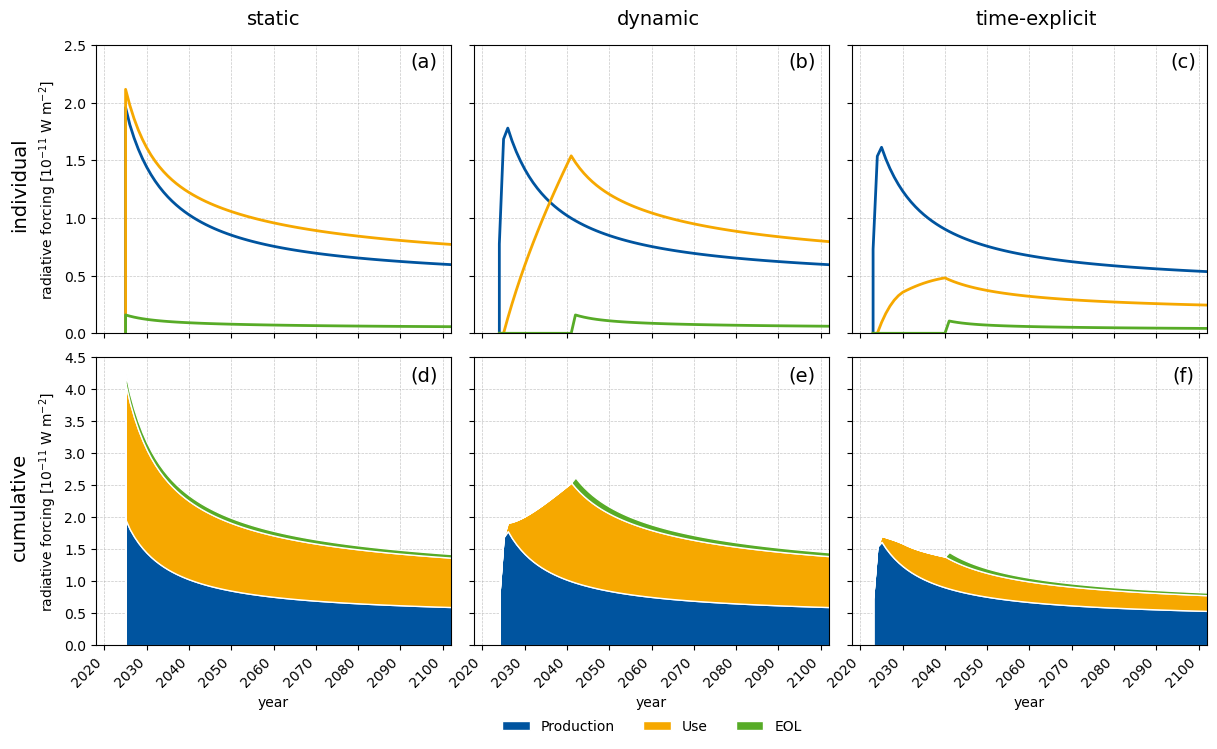

In [72]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.ticker import NullLocator

import pandas as pd
from datetime import datetime

# fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharex=True)
colors = ['#00549F', '#F6A800', '#57AB27',  '#AAAAAA']
labels = ['Production', 'Use', 'EOL', 'Cum. sum']

# Calculate global ylim
all_data = pd.concat([df_tlca.fillna(0), df_dlca.fillna(0)])
global_ylim = (0, 4.3)

# Plot data
df_tlca.fillna(0).plot(
    ax=axes[0, 2],
    linewidth=2,
    xlim=(datetime(2018, 1, 1), datetime(2102, 1, 1)),
    ylim=(0, 2.5),
    color=colors,
    legend=False,  # Suppress individual legends
)
df_dlca.fillna(0).plot(
    ax=axes[0, 1],
    linewidth=2,
    xlim=(datetime(2018, 1, 1), datetime(2102, 1, 1)),
    ylim=(0, 2.5),
    color=colors,
    legend=False,
)
df_dlca_no_tds.fillna(0).plot(
    ax=axes[0, 0],
    linewidth=2,
    xlim=(datetime(2018, 1, 1), datetime(2102, 1, 1)),
    ylim=(0, 2.5),
    color=colors,
    legend=False,
)

# df_tlca.fillna(0).plot.area(
#     ax=axes[1, 0],
#     stacked=True,
#     linewidth=0,
#     xlim=(datetime(2018, 1, 1), datetime(2100, 1, 1)),
#     ylim=global_ylim,
#     color=colors,
#     legend=False,
# )
axes[1, 2].stackplot(
    df_tlca.index,
    df_tlca["Production"].fillna(0),
    df_tlca["Use"].fillna(0),
    df_tlca["EOL"].fillna(0),
    labels=labels,
    colors=colors,
    edgecolor="white",
    linewidth=1,
)

axes[1, 1].stackplot(
    df_dlca.index,
    df_dlca["Production"].fillna(0),
    df_dlca["Use"].fillna(0),
    df_dlca["EOL"].fillna(0),
    labels=labels,
    colors=colors,
    edgecolor="white",
    linewidth=1,
)
axes[1, 0].stackplot(
    df_dlca_no_tds.index,
    df_dlca_no_tds["Production"].fillna(0),
    df_dlca_no_tds["Use"].fillna(0),
    df_dlca_no_tds["EOL"].fillna(0),
    labels=labels,
    colors=colors,
    edgecolor="white",
    linewidth=1,
)
# df_dlca.fillna(0).plot.area(
#     ax=axes[1, 1],
#     stacked=True,
#     linewidth=0,
#     xlim=(datetime(2018, 1, 1), datetime(2100, 1, 1)),
#     ylim=global_ylim,
#     color=colors,
#     legend=False,
# )

fig.text(0.21, 1, "static", ha='center', fontsize=14)
fig.text(0.53, 1, "dynamic", ha='center', fontsize=14)
fig.text(0.845, 1, "time-explicit", ha='center', fontsize=14)

fig.text(-0.01, 0.71, "individual", ha='left', fontsize=14, rotation=90)
fig.text(-0.01, 0.24, "cumulative", ha='left', fontsize=14, rotation=90)

# top left
# fig.text(0.04, 0.975, "(a)", ha='center')
# fig.text(0.53, 0.975, "(b)", ha='center')
# fig.text(0.04, 0.53, "(c)", ha='center')
# fig.text(0.53, 0.53, "(d)", ha='center')

# # top right
fig.text(0.335, 0.94, "(a)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
fig.text(0.65, 0.94, "(b)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
fig.text(0.968, 0.94, "(c)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
fig.text(0.335, 0.49, "(d)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
fig.text(0.65, 0.49, "(e)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
fig.text(0.968, 0.49, "(f)", ha='center', fontsize=14, backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))

axes[0, 0].set_ylabel("radiative forcing [10$^{-11}$ W m$^{-2}$]")
axes[1, 0].set_ylabel("radiative forcing [10$^{-11}$ W m$^{-2}$]")

axes[1, 0].set_xlabel("year")
axes[1, 1].set_xlabel("year")
axes[1, 2].set_xlabel("year")

# Create a single legend
handles, labels = axes[1, 1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.525, 0.025), frameon=False, markerscale=2
)

major_locator = mdates.YearLocator(10)  # Major ticks every 10 years
minor_locator = mdates.YearLocator(10)  # Minor ticks every year

for ax_rows in axes:
    for ax in ax_rows:
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_minor_locator(NullLocator())
        ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)
        # ax.set_yticks(np.arange(0, 5, 0.5))
        
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # Rotate the labels
            label.set_ha('right')   # Set horizontal alignment to right
            
# For the upper row of plots, set ylim to 2.5
for ax in axes[0]:  # Iterating over the first row
    ax.set_ylim((0, 2.5))

# For the lower row of plots, set ylim to 4
for ax in axes[1]:  # Iterating over the second row
    ax.set_ylim((0, 4.5))
    
# Remove y-axis tick labels for the first two plots in the first row
axes[0, 1].set_yticklabels([])
axes[0, 2].set_yticklabels([])
axes[1, 1].set_yticklabels([])
axes[1, 2].set_yticklabels([])

plt.tight_layout(w_pad=-0.4)
plt.savefig("radiative_forcing.svg", bbox_inches='tight')
plt.show()


### GWP

In [73]:
tlca.dynamic_lcia(metric="GWP")

/Users/timodiepers/anaconda3/envs/timex_nov22/lib/python3.11/site-packages/dynamic_characterization/dynamic_characterization.py:81: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions.                The flows that are characterized are based on the selection of the initially chosen impact category.                You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_function_dict.
  warnings.warn(


,date,amount,flow,activity
0,2022-01-01,-1.621040e-02,3269,109034
1,2022-01-01,-4.052738e-03,3269,109033
2,2022-01-01,-1.374486e-03,3211,109034
3,2022-01-01,-3.434914e-04,3211,109033
4,2022-01-01,1.394444e-26,1152,109033
...,...,...,...,...
2286,2040-01-01,1.465837e+01,1390,109065
2287,2040-01-01,2.631662e+01,107,109063
2288,2040-01-01,3.588365e+01,1031,109065
2289,2040-01-01,5.361418e+01,1031,109063


To compare the time-explicit results to prospective LCA results, we do additional calculations for cases where the entire supply chain comes from the years 2020, 2030 and 2040.

In [ ]:
import bw2calc as bc

try:
    prospective_driving = driving.copy(code="prospective_driving_2020", name="driving an electric vehicle in 2020")
except:
    foreground.get(code="prospective_driving_2020").delete()
    prospective_driving = driving.copy(code="prospective_driving_2020", name="driving an electric vehicle in 2020")
    

for exc in prospective_driving.technosphere():
    if exc.input == ev_production:
        prospective_ev_production = ev_production.copy(name="production of an electric vehicle in 2020")
        exc.input = prospective_ev_production
        exc.save()
        for subexc in prospective_ev_production.technosphere():
            subexc.input = bd.get_node(
                database=db_2020.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    elif exc.input == used_ev:
        prospective_used_ev = used_ev.copy(name="used electric vehicle in 2020")
        exc.input = prospective_used_ev
        exc.save()
        for subexc in prospective_used_ev.technosphere():
            subexc.input = bd.get_node(
                database=db_2020.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    else:
        exc.input = bd.get_node(
            database=db_2020.name,
            name=exc.input["name"],
            product=exc.input["reference product"],
            location=exc.input["location"],
        )
    exc.save()

prospective_scores_2020 = {}
lca = bc.LCA({prospective_driving.key: 1}, method)
lca.lci()
for exc in prospective_driving.technosphere():
    if exc.input["name"] in (prospective_ev_production["name"], prospective_used_ev["name"]):
        for subexc in exc.input.technosphere():
            lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            prospective_scores_2020[subexc.input["name"]] = lca.score
    else:
        lca.lcia(demand={exc.input.id: exc.amount})
        prospective_scores_2020[exc.input["name"]] = lca.score

In [88]:
try:
    prospective_driving = driving.copy(code="prospective_driving_2030", name="driving an electric vehicle in 2030")
except:
    foreground.get(code="prospective_driving_2030").delete()
    prospective_driving = driving.copy(code="prospective_driving_2030", name="driving an electric vehicle in 2030")
    

for exc in prospective_driving.technosphere():
    if exc.input == ev_production:
        prospective_ev_production = ev_production.copy(name="production of an electric vehicle in 2030")
        exc.input = prospective_ev_production
        exc.save()
        for subexc in prospective_ev_production.technosphere():
            subexc.input = bd.get_node(
                database=db_2030.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    elif exc.input == used_ev:
        prospective_used_ev = used_ev.copy(name="used electric vehicle in 2030")
        exc.input = prospective_used_ev
        exc.save()
        for subexc in prospective_used_ev.technosphere():
            subexc.input = bd.get_node(
                database=db_2030.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    else:
        exc.input = bd.get_node(
            database=db_2030.name,
            name=exc.input["name"],
            product=exc.input["reference product"],
            location=exc.input["location"],
        )
    exc.save()

prospective_scores_2030 = {}
lca = bc.LCA({prospective_driving.key: 1}, method)
lca.lci()
for exc in prospective_driving.technosphere():
    if exc.input["name"] in (prospective_ev_production["name"], prospective_used_ev["name"]):
        for subexc in exc.input.technosphere():
            lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            prospective_scores_2030[subexc.input["name"]] = lca.score
    else:
        lca.lcia(demand={exc.input.id: exc.amount})
        prospective_scores_2030[exc.input["name"]] = lca.score

In [89]:

try:
    prospective_driving = driving.copy(code="prospective_driving_2040", name="driving an electric vehicle in 2040")
except:
    foreground.get(code="prospective_driving_2040").delete()
    prospective_driving = driving.copy(code="prospective_driving_2040", name="driving an electric vehicle in 2040")
    

for exc in prospective_driving.technosphere():
    if exc.input == ev_production:
        prospective_ev_production = ev_production.copy(name="production of an electric vehicle in 2040")
        exc.input = prospective_ev_production
        exc.save()
        for subexc in prospective_ev_production.technosphere():
            subexc.input = bd.get_node(
                database=db_2040.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    elif exc.input == used_ev:
        prospective_used_ev = used_ev.copy(name="used electric vehicle in 2040")
        exc.input = prospective_used_ev
        exc.save()
        for subexc in prospective_used_ev.technosphere():
            subexc.input = bd.get_node(
                database=db_2040.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    else:
        exc.input = bd.get_node(
            database=db_2040.name,
            name=exc.input["name"],
            product=exc.input["reference product"],
            location=exc.input["location"],
        )
    exc.save()

prospective_scores_2040 = {}
lca = bc.LCA({prospective_driving.key: 1}, method)
lca.lci()
for exc in prospective_driving.technosphere():
    if exc.input["name"] in (prospective_ev_production["name"], prospective_used_ev["name"]):
        for subexc in exc.input.technosphere():
            lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            prospective_scores_2040[subexc.input["name"]] = lca.score
    else:
        lca.lcia(demand={exc.input.id: exc.amount})
        prospective_scores_2040[exc.input["name"]] = lca.score

Lets compare the overall scores:

In [90]:
print("Score 2030", sum(prospective_scores_2020.values())) # should be the same as tlca.base_lca.score
print("Score 2030: ", sum(prospective_scores_2030.values()))
print("Score 2040: ", sum(prospective_scores_2040.values()))
print("Time-explicit score: ", tlca.dynamic_score)

Score 2030 20858.470012031674
Score 2030:  9137.99912057819
Score 2040:  6522.389036408176
Time-explicit score:  12076.393848996588


Plotting this as a waterfall chart, comparing the different approaches:

In [91]:
colors = ['#00549F', '#F6A800', '#57AB27', "#CC071E", "#7A6FAC","#0098A1",  "#BDCD00","#006165",]

def plot_characterized_inventory_as_waterfall(
    lca_obj,
    prospective_scores=None,
    order_stacked_activities=None,
):
    time_res_dict = {
        "year": "%Y",
        "month": "%Y-%m",
        "day": "%Y-%m-%d",
        "hour": "%Y-%m-%d %H",
    }
    plot_data = lca_obj.characterized_inventory.copy()

    plot_data["year"] = plot_data["date"].dt.strftime(
        time_res_dict["year"]
    ) 

    # Optimized activity label fetching
    unique_activities = plot_data["activity"].unique()
    activity_labels = {
        idx: resolve_temporalized_node_name(
            lca_obj.activity_time_mapping_dict_reversed[idx][0][1]
        )
        for idx in unique_activities
    }
    plot_data["activity_label"] = plot_data["activity"].map(activity_labels)

    plot_data = plot_data.groupby(["year", "activity_label"], as_index=False)["amount"].sum()
    pivoted_data = plot_data.pivot(
        index="year", columns="activity_label", values="amount"
    )

    combined_data = []
    combined_data.append(pivoted_data)  # making sure the order is correct

    # Adding exchange_scores as a prospective column
    aggregated_row = pd.DataFrame(
        {col: [pivoted_data[col].sum()] for col in pivoted_data.columns}, 
        index=["sum"]
    )
    combined_data.append(aggregated_row)

    total_timex_score = aggregated_row.T.sum() / 1e3
    
    spacer_row = pd.DataFrame(
        {col: [np.nan] for col in combined_data[-1].columns}, index=[" "]
    )  # Create a spacer row with NaN values
    combined_data.append(spacer_row)  # Add the spacer row before prospective data

    for scores, yr in zip(prospective_scores, [2020, 2030, 2040]):
        prospective_data = pd.DataFrame(
            scores.items(), columns=["activity_label", "amount"]
        )
        prospective_data["year"] = f"static ({yr})"
        pivoted_prospective_data = prospective_data.pivot(
            index="year", columns="activity_label", values="amount"
        )
        combined_data.append(pivoted_prospective_data)

    combined_df = pd.concat(combined_data, axis=0)

    if order_stacked_activities:
        combined_df = combined_df[
            order_stacked_activities
        ]  # change order of activities in the stacked bars of the waterfall

    # Calculate the bottom for only the dynamic data
    dynamic_bottom = pivoted_data.sum(axis=1).cumsum().shift(1).fillna(0)

    # Add the spacer row to dynamic_bottom
    dynamic_bottom = pd.concat([dynamic_bottom, pd.Series([np.nan], index=[" "])])

    bottom = pd.concat([dynamic_bottom, pd.Series([0]),pd.Series([0]), pd.Series([0]), pd.Series([0])])

    # Reset NaN values in the spacer row to 0 for the bottom array
    bottom = bottom.fillna(0)  
    
    bottom=bottom/1e3

    activity_labels_simplified = {
        "treatment of used powertrain for electric passenger car, manual dismantling": "powertrain EOL",
        "market for used Li-ion battery": "battery EOL",
        "treatment of used glider, passenger car, shredding": "glider EOL",
        "market group for electricity, low voltage": "electricity generation",
        "powertrain production, for electric passenger car, without EOL": "powertrain production",
        "battery production, Li-ion, LiMn2O4, rechargeable, prismatic, without EOL": "battery production",
        "glider production, passenger car, without EOL": "glider production",
    }
    combined_df.columns = combined_df.columns.map(activity_labels_simplified)

    combined_df = combined_df / 1e3
    
    # Plotting
    ax = combined_df.plot(
        kind="bar",
        stacked=True,
        bottom=bottom,
        figsize=(9, 6),
        edgecolor="black",
        linewidth=0.5,
        color=colors,
        width=0.65,
    )
    ax.set_ylim((0, 23))
    ax.set_ylabel("GWP100 (static time horizon) [10$^{3}$ kg CO$_2$-eq]")
    ax.set_xlabel("time [years]")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha="right")

    # Add horizontal lines for waterfall structure
    cumulative_totals = combined_df.sum(axis=1).cumsum()
    for i in range(len(cumulative_totals) - 5):
        ax.hlines(
            y=cumulative_totals.iloc[i],
            xmin=i,
            xmax=i + 1,
            colors="gray",
            # linestyles="dashed",
            linewidth=1,
            zorder=0,
        )

    # vertical line separating static results
    vertical_line_x = len(combined_df) - 4
    ax.axvline(x=vertical_line_x, color="white", lw=2)
    ax.axvline(x=vertical_line_x, color="black", linestyle="--", lw=1)

    ax.axhline(y=float(total_timex_score), color="black", linestyle="dotted", lw=1, zorder=0)
    ax.text(-0.25, total_timex_score*1.02, "time-explicit score", va="bottom", style="italic", backgroundcolor='white', bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
    
    # 45 degree line separating x labels
    slope = 1.6
    xlen = 2
    ax.annotate(
        "",
        xy=(vertical_line_x, 0),
        xytext=(vertical_line_x-xlen, -slope*xlen),
        arrowprops=dict(
            arrowstyle="-",
            linestyle="--",
            color="black",
            linewidth=1,
            # clip_on=False,
        ),
    )

    ax.text(
        9,
        -3000/1e3,
        "time-explicit",
        ha="center",
        va="center",
    )
    
    total_2020 = sum(prospective_scores[0].values()) / 1e3
    ax.annotate('', xy=(len(combined_df)-2, total_timex_score), xytext=(len(combined_df)-2, total_2020), 
        arrowprops=dict(arrowstyle="->", color='black'))
    ax.text(x=len(combined_df)-2, y=(total_2020-total_timex_score)/2+total_timex_score, s=f"$\\times${round(float(total_timex_score)/total_2020, ndigits=1)}", ha="center", va="center", rotation=90, bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
    
    total_2030 = sum(prospective_scores[1].values()) / 1e3
    ax.annotate('', xy=(len(combined_df)-2, total_timex_score), xytext=(len(combined_df)-2, total_2030), 
        arrowprops=dict(arrowstyle="->", color='black'))
    ax.text(x=len(combined_df)-2, y=((total_2030-total_timex_score)/2+total_timex_score)*0.99, s=f"$\\times${round(float(total_timex_score)/total_2030, ndigits=1)}", ha="center", va="center", rotation=90, bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
    
    total_2040 = sum(prospective_scores[2].values()) / 1e3
    ax.annotate('', xy=(len(combined_df)-1, total_timex_score), xytext=(len(combined_df)-1, total_2040), 
        arrowprops=dict(arrowstyle="->", color='black'))
    ax.text(x=len(combined_df)-1, y=((total_2040-total_timex_score)/2+total_timex_score), s=f"$\\times${round(float(total_timex_score)/total_2040, ndigits=1)}", ha="center", va="center", rotation=90, bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))

    ax.hlines(y=total_2020, xmin=len(combined_df)-3, xmax=len(combined_df)-2, colors='black', linestyles='dotted', linewidth=1, zorder=0)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1], loc="upper left"
    )  # Reversing the order for the legend

    # remove tick at vertical line
    ticks, labels = ax.get_xticks(), ax.get_xticklabels()
    filtered_ticks_labels = [(tick, label.get_text()) for tick, label in zip(ticks, labels) if label.get_text() != " "]
    filtered_ticks, filtered_labels = zip(*filtered_ticks_labels)
    ax.set_xticks(filtered_ticks)
    ax.set_xticklabels(filtered_labels)
    ax.set_yticks(np.arange(0, 23, 2.5))
    
    ax.set_axisbelow(True)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("waterfall.svg")
    plt.show()

/var/folders/l1/k90rhb0j0ns58y35ymznsd700000gn/T/ipykernel_38402/3983954034.py:130: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axhline(y=float(total_timex_score), color="black", linestyle="dotted", lw=1, zorder=0)
/var/folders/l1/k90rhb0j0ns58y35ymznsd700000gn/T/ipykernel_38402/3983954034.py:160: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.text(x=len(combined_df)-2, y=(total_2020-total_timex_score)/2+total_timex_score, s=f"$\\times${round(float(total_timex_score)/total_2020, ndigits=1)}", ha="center", va="center", rotation=90, bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none"))
/var/folders/l1/k90rhb0j0ns58y35ymznsd700000gn/T/ipykernel_38402/3983954034.py:165: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

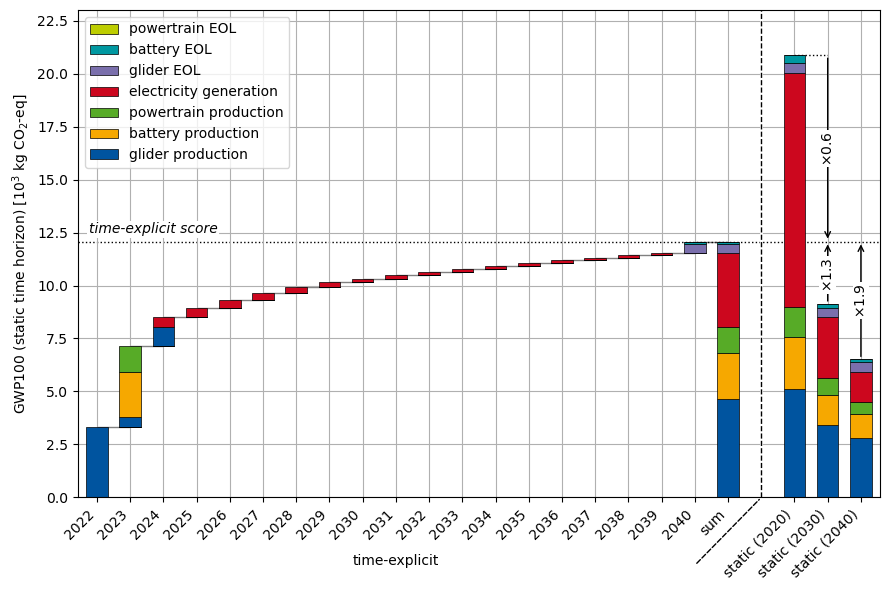

In [92]:
order_stacked_activities = (
    [ 
        glider_production_without_eol["name"],
        battery_production_without_eol["name"],
        powertrain_production_without_eol["name"],
        electricity_production["name"],
        glider_eol["name"],
        battery_eol["name"],
        powertrain_eol["name"],
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca,
    prospective_scores=[prospective_scores_2020, prospective_scores_2030, prospective_scores_2040],
    order_stacked_activities=order_stacked_activities,
)